## Imports

In [259]:
import ast
import pandas as pd
import numpy as np
import os
from os.path import abspath, join
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
from tqdm import tqdm
from matplotlib.figure import Figure
import pickle

from nipype.interfaces import fsl
from nipype.testing import example_data

from nilearn import image, plotting
from nilearn.image import get_data
from nilearn.image import load_img, math_img

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use("ggplot")
import seaborn as sns
import ptitprince as pt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import combinations

## Folder structure

In [2]:
experiment_dir = '/data/tu_aljedawi/DLT/'
logs_dir = experiment_dir + "data/behavior/logs/day_learning/"

participants = ['P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039',
                'P054', 'P055', 'P056', 'P057', 'P059', 'P061', 'P062', 'P063', 'P064',
                'P065', 'P066', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076']

# (master) functional space directory
if not os.path.exists(experiment_dir + "data/mri/functional_space"):
    os.makedirs(experiment_dir + "data/mri/functional_space") 
output_dir = experiment_dir + "data/mri/functional_space/"

# python objects directory
if not os.path.exists(output_dir + "python_objects"):
    os.makedirs(output_dir + "python_objects")
po_dir = output_dir + "python_objects/"

# freesurfer ROIs directory
rois_fs = ["hpc", "ec"]
for i_roi in rois_fs:
    if not os.path.exists(output_dir + "%s_lr" % i_roi):
        os.makedirs(output_dir + "%s_lr" % i_roi)

# MNI ROIs directory
rois_mni = ["aHPC", "alEC"]
for i_roi in rois_mni:
    if not os.path.exists(output_dir + "mni/%s_lr" % i_roi):
        os.makedirs(output_dir + "mni/%s_lr" % i_roi)
    
    # intersected masks directory
    if not os.path.exists(output_dir + "intersected_masks/%s_lr" % i_roi):
        os.makedirs(output_dir + "intersected_masks/%s_lr" % i_roi)
    
    # timeseries directory
    if not os.path.exists(output_dir + "time_series/%s_lr" % i_roi):
        os.makedirs(output_dir + "time_series/%s_lr" % i_roi)
        
    # correlation matrices directory
    if not os.path.exists(output_dir + "correlation_matrices/%s_lr" % i_roi):
        os.makedirs(output_dir + "correlation_matrices/%s_lr" % i_roi)

# Loading the Data Sets

# Temporal Logs
Load the temporal logs data from the relevant text files into a dictionary with the participant's number as the dictionary `key` and a dataframe of the participant's logs data as its `value`. Following this format: `logs = {'P0XX' : DataFrame[...]}`

In [3]:
%%time

logs = {}
for filename in os.listdir(logs_dir):
    if filename.endswith(".txt") and filename.startswith(tuple(participants)):
        key = filename.split('-')[0]
        data = pd.read_csv(os.path.join(logs_dir,filename), sep="\t", header=None)
        data.columns =['fc_on', 'fc_off', 'cue_start', 'cue_id', 'blkscrn_on', 'volume',
                       'repetition', 'real_time', 'virtual_day', 'trial_endtime']
        logs[key] = data
        
    else:
        continue

logs.items()

CPU times: user 167 ms, sys: 8.61 ms, total: 176 ms
Wall time: 863 ms


dict_items([('P062',        fc_on   fc_off  cue_start  cue_id  blkscrn_on  volume  repetition  \
0      14733    18766      18767    6.58       20282       9           1   
1      20282    21016      21039   10.00       22539      10           1   
2      22539    23315      23316    8.03       24832      11           1   
3      24832    30382      30405    1.00       31915      15           1   
4      31915    34081      34082   10.38       35598      16           1   
..       ...      ...        ...     ...         ...     ...         ...   
303  2398472  2404238    2404238   15.55     2405755    1060           7   
304  2405755  2406321    2406345   19.00     2407855    1061           7   
305  2407855  2409354    2409355   16.44     2410871    1063           7   
306  2410871  2418820    2418845   16.00     2420354    1067           7   
307  2420354  2426087    2426087   19.25     2427603    1070           7   

     real_time  virtual_day  trial_endtime  
0       4.0207       

In [240]:
logs['P064'].head()

,fc_on,fc_off,cue_start,cue_id,blkscrn_on,volume,repetition,real_time,virtual_day,trial_endtime
0,20793,24266,24266,8.33,25782,12,1,3.4649,2,25782
1,25782,30182,30204,13.00,31705,14,1,9.3750,2,31705
2,31705,33715,33716,10.04,35232,16,1,12.9010,2,35232
3,35232,39565,39587,18.00,41098,19,1,18.7500,2,41098
4,41098,51014,51015,12.50,52531,24,1,30.2088,2,52531


# Regions of Interest (ROI)

We want to combine masks from the individual Freesurfer segmentations of the HPC and EC with masks dividing the subregions of the HPC and EC.

The participants' Freesurfer masks are saved in /data/mri/rois/hpc_lr/freesurfer_highres_space, and the standard MNI masks are saved in /data/mri/rois/mni_masks. All masks will be co-registered to the analysis space, which is the space of the functional images. This relies on the FSL transformation matrices and warp files stored in the /data/mri/processed for each participant.

**1. Apply flirt**   
To co-register both Freesurfer and standard MNI masks to the functional space.


**2. Binarize the outputs**   
Before intersecting the resulting ROIs from previous steps, we first need to binarize the masked ROIs using a threshold. We chose this threshold to be 0.5 in this case. This step is required because the previous co-registeration steps resulted in matrices of type float due to the mathmatical transformations that were applied on the masks.  

**3. Intersect the binarized output masks**  

In [5]:
def flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat):
    flt = fsl.FLIRT(apply_xfm=True, verbose=0)
    flt.inputs.in_file = input_dir
    flt.inputs.reference = ref_dir
    flt.inputs.in_matrix_file = mat_dir
    flt.inputs.out_file = out_file
    flt.inputs.out_matrix_file = out_mat
    #print(flt.cmdline)
    result = flt.run()
    return result

## Coregister Freesurfer masks to functional space

In [6]:
%%time

# threshold for binarizing the output masks
threshold = 0.5

# ROIs of freesrufer masks
rois_fs = ["hpc", "ec"]

def run_highres2func():
    for i_roi in rois_fs:
        #print(i_roi)
        working_dir = join(output_dir,"%s_lr/" %(i_roi))
        i=0

        for p in participants:
            i+=1
            input_dir = join(experiment_dir, "data/mri/rois/%s_lr/freesurfer_highres_space/%s_%s_lr_fs_hs.nii.gz" % (i_roi,p,i_roi))
            #print(str(i) + input_dir)
            ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
            #print(str(i) + ref_dir)
            mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/highres2example_func.mat" % p)
            #print(str(i) + mat_dir)
            out_file = join(working_dir, "%s_%s_fs.nii.gz" % (p,i_roi))
            #print(str(i) + out_file)
            out_mat = join(working_dir, "%s_%s_fs_hs_flirt.mat" % (p,i_roi))
            #print(str(i) + out_mat)
            res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
            #print(res.outputs)

            # use math_img to binarize the masked ROIs using a threshold of 0.5
            binary_mask = math_img(f'img > {threshold}', img=out_file)
            binary_mask.to_filename(join(working_dir, "%s_%s_fs_binary.nii.gz" % (p,i_roi)))
            
#run_highres2func()

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 19.6 µs


## Atlas masks

In [7]:
%%time

rois_mni = ["aHPC", "alEC"]

def run_standard2func():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"mni/%s_lr/" %(i_roi))
        i=0

        for p in participants:
            i+=1
            input_dir = join(experiment_dir, "data/mri/rois/mni_masks/%s_lr.nii.gz" % (i_roi))
            #print(str(i) + input_dir)
            ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
            #print(str(i) + ref_dir)
            mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/standard2example_func.mat" % p)
            #print(str(i) + mat_dir)
            out_file = join(working_dir, "%s_%s_mni.nii.gz" % (p,i_roi))
            #print(str(i) + out_file)
            out_mat = join(working_dir, "%s_%s_mni_flirt.mat" % (p,i_roi))
            #print(str(i) + out_mat)
            res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
            #print(res.outputs)

            # use math_im to binarize the masked ROIs using a threshold of 0.5
            binary_mask = math_img(f'img > {threshold}', img=out_file)
            binary_mask.to_filename(join(working_dir, "%s_%s_mni_binary.nii.gz" % (p,i_roi)))
            
#run_standard2func()

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 16.2 µs


## Intersecting the masks
In the last step, we intersect the masks from Freesurfer with the respective subregion masks. At this point, both masks are in the functional analysis space and have been binarized. Finally, we generate a PDF of diagnostic plots to check the final ROI masks.

In [8]:
%%time

rois_mni = ["aHPC", "alEC"]
rois_fs = {"aHPC":"hpc", "alEC":"ec"}

roi_imgs = []
titles = []
bg_imgs = []

imasks = {}
imasks = {"aHPC":{p:0 for p in participants},
         "alEC":{p:0 for p in participants}}

for i_roi in rois_mni:
    working_dir = join(output_dir,"intersected_masks/%s_lr/" %(i_roi))
    #print(working_dir)
    f_roi = rois_fs[i_roi]
    
    for p in participants:
        fs = load_img(join(output_dir, "%s_lr/%s_%s_fs_binary.nii.gz" %(f_roi,p,f_roi)))
        mn = load_img(join(output_dir, "mni/%s_lr/%s_%s_mni_binary.nii.gz" %(i_roi,p,i_roi)))
        intersec_mask = math_img('img1 * img2', img1=fs, img2=mn)
        intersec_mask.to_filename(join(working_dir, "%s_%s.nii.gz" %(p,i_roi)))
        #print("out_file =", join(working_dir,"%s_%s.nii.gz" %(p,i_roi)))
        imasks[i_roi][p] = intersec_mask
        
        # saving the outputs to generate a PDF of diagnostic plots of the final ROI masks
        roi_img = join(working_dir,"%s_%s.nii.gz" %(p,i_roi))
        bg_img = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mean_func.nii.gz" %p)
        t = ("%s_%s" %(p,i_roi))
        roi_imgs.append(roi_img)
        bg_imgs.append(bg_img)
        titles.append(t)

with open(join(po_dir, "intersected_masks_all.pickle"),"wb") as f:
    pickle.dump(imasks, f)

print("Finished interesecting a total of %d ROI masks in the functional space" % len(roi_imgs))

Finished interesecting a total of 54 ROI masks in the functional space
CPU times: user 14.5 s, sys: 459 ms, total: 15 s
Wall time: 16.1 s


### PDF of diagnostic plots generation

In [9]:
%%time

# Plot multiple figures into a single PDF with matplotlib, using the object-oriented interface
plts = zip(roi_imgs, titles, bg_imgs)

def pdf_diagnostics():
    with PdfPages(join(output_dir,"intersected_masks/ROIs_ALL.pdf")) as pages:
        for pl in plts:
            fig = Figure()
            ax = fig.gca()
            plotting.plot_roi(pl[0],title=pl[1], display_mode='ortho', annotate=False, draw_cross=False,
                              cmap="cool", black_bg=True, bg_img=pl[2], axes=ax)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)

    print("PDF of diagnostic plots of the final ROI masks is generated in:\n",
          join(output_dir,"intersected_masks/ROIs_ALL.pdf"))

#pdf_diagnostics()

CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 34.3 µs


In [10]:
# find the coordinates 
# display = plotting.plot_roi(pl[0],title=pl[1], display_mode='ortho', annotate=False, draw_cross=False,
#                             cmap="cool", black_bg=True, bg_img=pl[2])

# Get multi-voxel patterns from ROIs

In [11]:
# a custom function similar to FSL_info func
def fsl_info(arr):
    # Printing type of arr object
    print("Array is of type: ", type(arr))
    # Printing array dimensions (axes)
    print("No. of dimensions: ", arr.ndim)
    # Printing shape of array
    print("Shape of array: ", arr.shape)
    # Printing size (total number of elements) of array
    print("Size of array: ", arr.size)
    # Printing type of elements in array
    print("Array stores elements of type: ", arr.dtype)

## Extract ROI time series

 0. Load all filtered_func, masks matrices
 1. a = Reduce my intersected mask matrix to 1D vector
 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
 4. Output is: P064_aHPC_timeseries, save them as csv or pickle

In [12]:
%%time
RELOAD_DATA = False

# Load the functional data (filtered_func NIFTIs) for all participants and pickle it out as a Python object
def load_filteredfunc_data():
    filtered_func_all = {}
    filtered_func_all = {p:0 for p in participants}

    for p in participants:
        ffunc_nii = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/filtered_func_data.nii.gz" %p)
        ffunc_data = get_data(ffunc_nii)
        filtered_func_all[p] = ffunc_data
    
    with open(join(po_dir, "filtered_func_all.pickle"),"wb") as f:
        pickle.dump(filtered_func_all, f)
    return filtered_func_all
        


if not os.path.exists(join(po_dir, "filtered_func_all.pickle")) or RELOAD_DATA:
    print("Loading functional data for the first time (approx. 35 min)")
    filtered_func_all = load_filteredfunc_data()
    
else:
    print("Loading saved functional data (approx. 5 min)")
    with open(join(output_dir, "python_objects/filtered_func_all.pickle"),"rb") as f:
        filtered_func_all = pickle.load(f)

#dict(list(filtered_func_all.items())[0:2])

Loading saved functional data (approx. 5 min)
CPU times: user 1min 2s, sys: 3min 49s, total: 4min 51s
Wall time: 5min 3s


In [13]:
%%time

rois_mni = ["aHPC", "alEC"]

def create_fmri_timeseries():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))

        for p in participants:        
            a = get_data(imasks[i_roi][p])
            b = filtered_func_all[p]

            # 1. a = Reduce my intersected mask matrix to 1D vector
            a_re = np.reshape(a, a.size)

            # 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
            b_re = np.reshape(b, (b.shape[0]*b.shape[1]*b.shape[2], b.shape[-1]))

            # 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
            b_timeseries = b_re[(a_re == 1),:]

            # 4. Output example is: P064_aHPC_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_timeseries.csv" % (p,i_roi)), b_timeseries, delimiter=",")


# (approx. 34min 34s)
#create_fmri_timeseries()

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 14.5 µs


In [14]:
%%time

# test output of create_fmri_timeseries for one participant
p_test = "P064"
i_roi_test = "aHPC"

a_test = get_data(imasks[i_roi_test][p_test])
b_test = filtered_func_all[p_test]

# 1. a = Reduce my intersected mask matrix to 1D vector
a_re_test = np.reshape(a_test, a_test.size)

# 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
b_re_test = np.reshape(b_test, (b_test.shape[0]*b_test.shape[1]*b_test.shape[2], b_test.shape[-1]))

# 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
b_timeseries_test = b_re_test[(a_re_test == 1),:]

print("For participant "+ p_test + " (" + i_roi_test + "):")
print("1) a.shape:", a_test.shape)
print("1) a_reduced.shape:", a_re_test.shape)
print("\n2) b.shape:", b_test.shape)
print("2) b_reduced.shape:", b_re_test.shape)
print("\n3) b_timeseries.shape:", b_timeseries_test.shape)

For participant P064 (aHPC):
1) a.shape: (140, 140, 40)
1) a_reduced.shape: (784000,)

2) b.shape: (140, 140, 40, 1078)
2) b_reduced.shape: (784000, 1078)

3) b_timeseries.shape: (751, 1078)
CPU times: user 31.8 s, sys: 3.4 s, total: 35.2 s
Wall time: 35.2 s


## Calculate residuals from motion parameter regression
The purpose of this step is to remove the chuncks from my ROI timeseries that can be explained by motion.

 1. Build a linear model to predict voxels time series using MC parameters
 2. Visualize your timeseries against your model prediction
 3. Take my residuals as the cleaned up data 
 4. Output is: P064_aHPC_timeseries_cleaned, save it as csv

In [16]:
# load the ROI timeseries (combined mask)
def read_timeseries(participant, roi):
    file = join(output_dir,"time_series/%s_lr/%s_%s_timeseries.csv" % (roi,participant,roi))
    df = pd.read_csv(file, header=None)
    return df

print(p)
print(i_roi)
roi_dat = read_timeseries(p, i_roi)
print(roi_dat.shape)
roi_dat.head()

P076
alEC
(274, 1079)


,0,1,2,3,4,5,6,7,8,9,...,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078
0,6255.348633,5517.013672,8569.105469,5943.458984,7598.626465,7089.021973,7026.796387,7449.525391,6641.913086,7293.722168,...,6117.317871,6627.331543,7200.111328,6446.106934,5680.716797,6520.810547,7782.739746,5388.173828,7881.774902,7401.977051
1,8879.619141,9151.776367,8777.138672,9158.523438,8660.260742,8760.853516,9069.361328,8979.682617,9660.172852,9384.667969,...,9582.186523,8751.456055,10025.451172,9522.664062,10020.382812,9661.492187,9231.153320,8269.376953,7992.207031,7588.378418
2,7901.391602,7833.554688,7521.107422,7627.083008,7191.354980,7306.405273,8063.634277,7566.787598,8544.792969,8512.034180,...,8647.332031,7984.012695,8072.369629,7677.291504,8448.659180,6937.264160,6445.373535,7156.716797,7796.354492,8453.771484
3,6905.845215,5962.428223,5482.562012,6254.356445,4496.073242,5730.726074,6062.682129,7059.466797,5435.224121,5690.756348,...,5788.956543,6003.930664,6716.985840,5696.325684,6621.411133,6519.264160,5637.995605,5082.605469,6097.699219,6020.948242
4,6947.690430,5385.154785,6255.207520,5208.219238,4810.396484,6688.568359,5375.899414,5268.395020,5780.445801,6238.630371,...,5843.647461,5046.198730,5529.771484,6322.297852,7269.939453,4589.274414,5665.487305,5521.723145,6313.195312,5853.408203


In [17]:
%%time

rois_mni = ['aHPC', 'alEC']

def run_motion_glm():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))

        for p in participants:
            # load the motion params and convert to a pandas dataframe
            mc_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mc/prefiltered_func_data_mcf_final.par"%p)
            mp_df = pd.read_csv(mc_dir, header=None, delimiter=r"\s+")
            mp_df.columns = ["mp" + str(num) for num in range(1,7)]

            # load the ROI timeseries (combined mask)
            roi_dat = read_timeseries(p, i_roi)
            roi_dat = roi_dat.loc[(roi_dat!=0).any(axis=1)] # remove rows with all 0s 

            roi_dat_clean = np.zeros(roi_dat.shape)

            for i_vox in range(roi_dat.shape[0]):
                #print(i_vox)
                # extract this voxel's data and merge with motion params
                vox_dat = roi_dat.iloc[i_vox,]
                vox_df = vox_dat.to_frame()
                vox_df.columns = ["vox_dat"]
                #print(vox_df.shape)
                #print(mp_df.shape)
                vox_df = pd.concat([vox_df, mp_df], axis=1)

                # linear model
                model = smf.glm(formula = 'vox_dat~mp1+mp2+mp3+mp4+mp5+mp6', data=vox_df)
                result = model.fit()
                #print(result.summary())
                roi_dat_clean[i_vox,] = result.resid_response

            # Output example is: P064_aHPC_clean_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_clean_timeseries.csv" % (p,i_roi)), roi_dat_clean, delimiter=",")

# (approx. 40 min)
#run_motion_glm()

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 18.4 µs


In [18]:
# load the ROI timeseries (combined mask)
def read_clntimeseries(participant, roi, dataframe=False):
    file = join(output_dir,"time_series/%s_lr/%s_%s_clean_timeseries.csv" % (roi,participant,roi))
    return np.genfromtxt(file, delimiter=',')

# Temporal Auto-Correlation of Multi-Voxel Patterns

**Question**: Do representational states evolve at different speeds when the virtual clock is moving fast or slow?

1. Extract multi-voxel patterns for each TR of a given day
2. calculate time-lagged correlations (each TR with the subsequent TR)
3. compare correlations between days when virtual clock is fast or slow

In [19]:
virtual_days = range(1,5)
repetitions = range(1,8)
read_clntimeseries(p, i_roi).shape[0]

274

In [20]:
%%time
RELOAD_DATA = False

def extract_virtualdays_data():
    vdays_dat = {}
    vdays_dat = {"aHPC":{p:{v:{rep:0 for rep in repetitions} for v in virtual_days} for p in participants},
                 "alEC":{p:{v:{rep:0 for rep in repetitions} for v in virtual_days} for p in participants}}

    for i_roi in rois_mni:
        print("Current ROI: ", i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))

        for p in participants:
            #print(p)
            roi_dat_clean = read_clntimeseries(p, i_roi)
            i = roi_dat_clean.shape[0]
            for vd in virtual_days:
                #print(vd)
                for rep in repetitions:
                    #print(rep)
                    start_vol = int((logs[p][(logs[p].virtual_day==vd) & (logs[p].block==rep)].volume).head(1))
                    end_vol = int(((logs[p][(logs[p].virtual_day==vd) & (logs[p].block==rep)].volume)).tail(1))
                    j = end_vol - start_vol
                    vox_vol = np.zeros(i*j).reshape(i,j)
                    #print(vox_vol.shape)
                    vdays_dat[i_roi][p][vd][rep] = roi_dat_clean[:,start_vol+2:end_vol+2]

    with open(join(po_dir, "virtualdays_dat_all.pickle"),"wb") as f:
        pickle.dump(vdays_dat, f)

    return vdays_dat


if not os.path.exists(join(po_dir, "virtualdays_dat_all.pickle")) or RELOAD_DATA:
    print("Extracting virtual days data...")
    vdays_dat = extract_virtualdays_data()
    
else:
    print("Loading already extracted virtual days data...")
    with open(join(po_dir, "virtualdays_dat_all.pickle"),"rb") as f:
        vdays_dat = pickle.load(f)

dict(list(vdays_dat.items())[0:1])

Loading already extracted virtual days data...
CPU times: user 112 ms, sys: 216 ms, total: 327 ms
Wall time: 363 ms


{'aHPC': {'P031': {1: {1: array([[  399.33698504,   340.8104022 ,  -773.89644454, ...,
             -344.8653735 ,  -617.91162559,  1038.78838828],
           [ -908.69299994,  -244.94603995,   938.4048016 , ...,
             -363.34210548,  -156.86269917,  -739.59347291],
           [ -265.41091572,  -784.13193852,   -86.68755455, ...,
              269.89700116,   814.9229772 ,   761.08204049],
           ...,
           [ -275.77259928,  -421.42078116,   825.92542404, ...,
             -687.85748588,  -726.90325314, -1166.18483508],
           [ -142.45164738,   669.31992252,  -943.02815659, ...,
              921.58366787,   717.9977102 ,  -990.92256833],
           [ 1097.45191477,    -6.16915711,   507.92478596, ...,
             -611.96079135,   403.29938261,  1053.32863964]]),
    2: array([[  -12.86182276,  -101.60592941,   121.30679882, ...,
             -431.54976945, -1350.77230903,  -657.4364956 ],
           [  367.36051877,   132.6624347 ,    79.61813554, ...,
          

## Inter-voxel similarity
Every **trial** consists of a virtual day and a repetition. Thus, for a given ROI and a given participant, we have a total of 28 trials (four virtual days and seven repetition per day).
<pre><code>
for each ROI:   
    for each participant:     
        for each virtual day:     
            for each repetition of that virtual day: 
             - I have a voxel-by-time courses matrix B.
             - I want to create a voxel-by-voxel correlation matrix of matrix B. In other words, I take
             every row (voxel) of matrix B and correlate it with every row in that matrix. The result is
             a new matrix of correlation coefficients for every voxel with other voxel.
</code></pre>
Next,   
1. Reduce these matrices to lower (or upper) half.
2. Vectorize them.
3. Create 54 nx28 matrices (voxel by trial) per participant per ROI. Then, correlate the columns of those matrices to get 28x8 (trial by trial) correlation matrix per participant.

In [21]:
trials = []
for d in ["D" + str(num) for num in range(1,5)]:
    for r in ["R" + str(num) for num in range(1,8)]:
        trials.append(d+r)
    
len(trials)

28

In [22]:
%%time
RELOAD_DATA = False

# define inter_voxel_trial_corr function
# What it does:
# Calculates correlation matrix, removes diagonal, and z-transforms the correlation values
#

trial_corr_all = {}
trial_corr_all = {"aHPC":{p:0 for p in participants},
                  "alEC":{p:0 for p in participants}}

def inter_voxel_trial_corr():
    
    for i_roi in rois_mni:
        print("Current ROI:", i_roi)
        working_dir = join(output_dir,"correlation_matrices/%s_lr/" %(i_roi))

        for p in participants:
            #print("Participant:", p)
            
            voxpair_by_trial = pd.DataFrame()

            for vd in virtual_days:
                #print("Virtual Day:", vd)

                for rep in vdays_dat[i_roi][p][vd].keys():
                    #print(rep)
                    voxels = vdays_dat[i_roi][p][vd][rep]

                    # we need to transpose the matrix because pandas.DF.corr() computes correlation of columns
                    voxels_transposed = np.transpose(voxels)
                    df_corr = pd.DataFrame(voxels_transposed).corr()
                    
                    # reduece and vectorize the voxel-by-voxel correlation matrix
                    vech_corr = np.triu(df_corr) # upper triangle of corr matrix
                    vech_corr = vech_corr.flatten() # vectorize matrix to 1D
                    vech_corr = vech_corr[vech_corr < 1] # remove diagnol
                    interv_z = np.arctanh(vech_corr) # fisherz-transforms the correlation values
                    
                    voxpair_by_trial = pd.concat([voxpair_by_trial,pd.Series(interv_z)], axis=1)
                    # TODO: average this series and visulaize it to contrast with final trial_corr
                    
            trial_corr = voxpair_by_trial.corr() # 28x28
            trial_corr.index = trials
            trial_corr.columns = trials
            
            trial_corr.to_csv(join(working_dir,"%s_%s_trial_corr.csv" %(p,i_roi)))
            print("Created 28x28 trial correlation matrix for participant %s" %(p))
            
            trial_corr_all[i_roi][p] = trial_corr
            
    with open(join(po_dir, "trial_corr_all.pickle"),"wb") as f:
        pickle.dump(trial_corr_all, f)
        
    return trial_corr_all


if not os.path.exists(join(po_dir, "trial_corr_all.pickle")) or RELOAD_DATA:
    print("Creating trials correlation matrices for the first time (approx. 8 min)...")
    trial_corr_all = inter_voxel_trial_corr()
    
else:
    print("Loading already created correlation matrices...")
    with open(join(po_dir, "trial_corr_all.pickle"),"rb") as f:
        trial_corr_all = pickle.load(f)

dict(list(trial_corr_all.items())[0:1])

Loading already created correlation matrices...
CPU times: user 50.4 ms, sys: 0 ns, total: 50.4 ms
Wall time: 62 ms


{'aHPC': {'P031':           D1R1      D1R2      D1R3      D1R4      D1R5      D1R6      D1R7  \
  D1R1  1.000000  0.003870  0.005248  0.003575  0.002542  0.004878  0.002633   
  D1R2  0.003870  1.000000  0.001842  0.002575  0.005045  0.001849  0.005017   
  D1R3  0.005248  0.001842  1.000000  0.003443  0.002788  0.003118  0.004573   
  D1R4  0.003575  0.002575  0.003443  1.000000  0.004555  0.002884  0.007214   
  D1R5  0.002542  0.005045  0.002788  0.004555  1.000000  0.006486  0.002295   
  D1R6  0.004878  0.001849  0.003118  0.002884  0.006486  1.000000  0.007499   
  D1R7  0.002633  0.005017  0.004573  0.007214  0.002295  0.007499  1.000000   
  D2R1  0.006407  0.006524  0.003872  0.004252  0.004525  0.002789  0.007843   
  D2R2  0.005005  0.004041  0.005109  0.003617  0.005482  0.005415  0.002925   
  D2R3 -0.000096  0.000289  0.003120  0.004096  0.004973  0.003646  0.005310   
  D2R4  0.003605  0.005453  0.003132  0.003055  0.003133  0.004571  0.004947   
  D2R5  0.000707  0.0054

In [23]:
trial_corr_all['aHPC']['P064']

,D1R1,D1R2,D1R3,D1R4,D1R5,D1R6,D1R7,D2R1,D2R2,D2R3,...,D3R5,D3R6,D3R7,D4R1,D4R2,D4R3,D4R4,D4R5,D4R6,D4R7
D1R1,1.000000,0.003598,0.003955,0.004887,0.005469,0.005826,0.002213,0.005544,0.004447,0.003091,...,0.002377,0.001097,0.006600,0.000520,0.000239,0.003323,0.003941,0.003060,0.007308,0.002648
D1R2,0.003598,1.000000,0.008182,-0.000512,0.000509,0.002938,0.004637,0.001530,0.001971,0.003475,...,0.005216,0.000346,0.006580,0.000247,-0.000087,0.001452,0.001823,0.005865,-0.000112,0.002262
D1R3,0.003955,0.008182,1.000000,0.001963,0.002462,0.008122,0.009302,0.008860,0.004861,0.003522,...,0.008748,0.003995,0.007599,0.003917,0.003432,0.005380,0.005075,0.004618,0.003668,0.007398
D1R4,0.004887,-0.000512,0.001963,1.000000,0.000299,0.001341,-0.000379,0.001573,0.001810,0.000397,...,0.003136,0.000298,-0.000452,-0.000371,0.001085,0.001074,0.002760,0.005771,0.003706,0.005700
D1R5,0.005469,0.000509,0.002462,0.000299,1.000000,0.002852,0.007300,-0.002688,0.001435,0.002488,...,0.008082,0.001686,0.002799,0.000638,0.003573,0.001298,-0.000313,0.004121,0.006900,0.004211
D1R6,0.005826,0.002938,0.008122,0.001341,0.002852,1.000000,0.003766,0.001344,0.002053,0.002329,...,0.001771,0.008284,0.005451,0.002836,0.001863,0.000513,0.003500,0.002017,0.008316,0.003908
D1R7,0.002213,0.004637,0.009302,-0.000379,0.007300,0.003766,1.000000,0.003414,0.001355,0.007055,...,0.006555,0.002034,0.007754,0.008324,0.004039,0.003181,0.002296,0.004012,0.004557,0.004060
D2R1,0.005544,0.001530,0.008860,0.001573,-0.002688,0.001344,0.003414,1.000000,0.003833,0.003766,...,0.005242,0.004447,0.004611,0.002141,-0.000137,0.004917,0.004794,0.003408,0.001981,0.002920
D2R2,0.004447,0.001971,0.004861,0.001810,0.001435,0.002053,0.001355,0.003833,1.000000,-0.000261,...,0.003012,0.001641,0.005951,0.003878,0.001026,0.001768,0.001388,0.007123,-0.001725,0.002906
D2R3,0.003091,0.003475,0.003522,0.000397,0.002488,0.002329,0.007055,0.003766,-0.000261,1.000000,...,0.000589,0.000335,0.005393,0.000994,0.003872,0.003689,0.002965,0.004986,-0.000256,0.002993


## Representational Similarity Analysis
The next step is to compare these correlation matrices, e.g. between the different repetitions of one virtual day or also between two virtual days.

4. Average the 54 trial-by-trial matrices and plot the average matrix per ROI after labeling your columns using `D1R1, D1R2, ..., D1R7, ..., D4R7`
5. Create a prediction matrix and compare it with the neural matrix.

In [24]:
a = []
b = []

for i_roi in rois_mni:
        print("Current ROI:", i_roi)
        working_dir = join(output_dir,"correlation_matrices/%s_lr/" %(i_roi))
        
        for k,v in trial_corr_all[i_roi].items():
            if i_roi == 'aHPC':
                a.append(v)
            elif i_roi == 'alEC':
                b.append(v)

            
aHPC_trial_corr = pd.concat(a).groupby(level=0).mean()
alEC_trial_corr = pd.concat(b).groupby(level=0).mean()

aHPC_trial_corr.to_csv(join(output_dir,"correlation_matrices/aHPC_lr/avg_aHPC_trial_corr.csv"))
alEC_trial_corr.to_csv(join(output_dir,"correlation_matrices/alEC_lr/avg_alEC_trial_corr.csv"))

Current ROI: aHPC
Current ROI: alEC


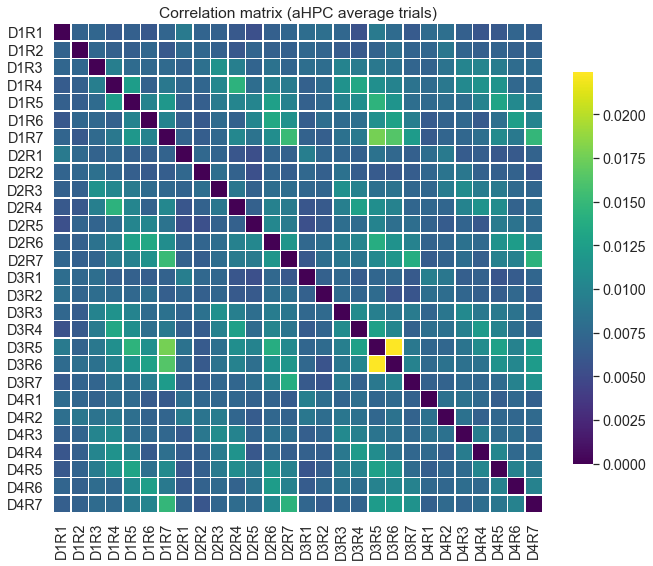

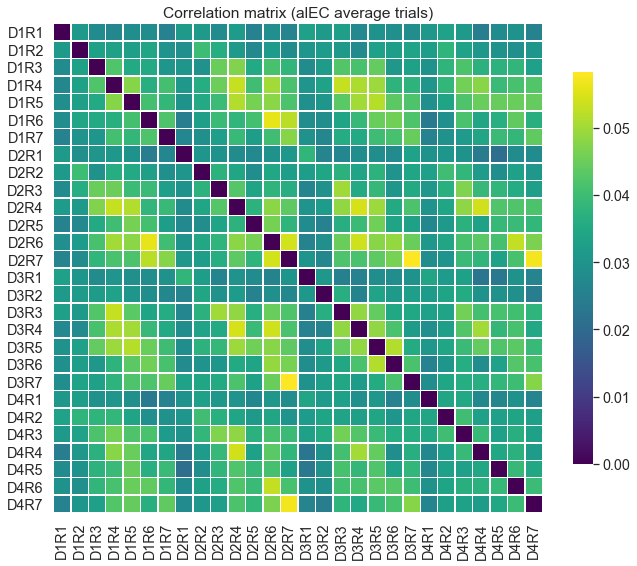

In [581]:
# reset diagnol values to 0s for more visability in the heatmap
np.fill_diagonal(aHPC_trial_corr.to_numpy(), 0)
np.fill_diagonal(alEC_trial_corr.to_numpy(), 0)
#print(aHPC_trial_corr.head())
#print(alEC_trial_corr.head())

# aHPC
sns.set(style="white", font_scale=1.3)
df = aHPC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title("Correlation matrix (aHPC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/aHPC_lr/aHPC_trial_corr.png"), dpi=90)

# alEC
df = alEC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title("Correlation matrix (alEC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/alEC_lr/alEC_trial_corr.png"), dpi=90)

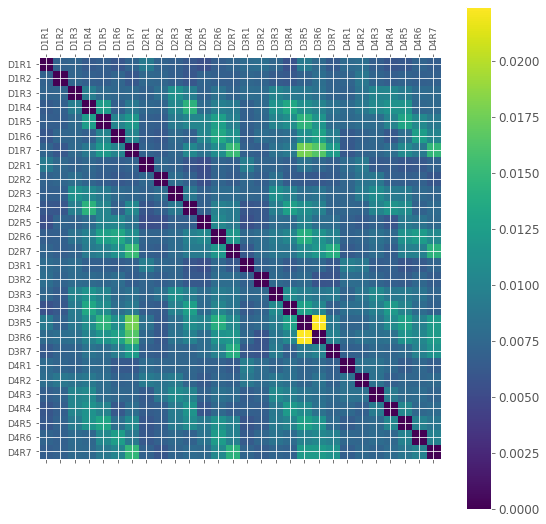

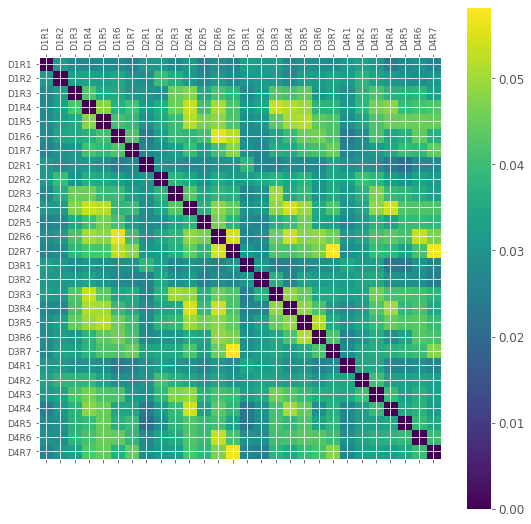

In [29]:
# # reset diagnol values to 0s for more visability in the heatmap
# np.fill_diagonal(aHPC_trial_corr.to_numpy(), 0)
# np.fill_diagonal(alEC_trial_corr.to_numpy(), 0)
# #print(aHPC_trial_corr.head())
# #print(alEC_trial_corr.head())

# df = aHPC_trial_corr
# f = plt.figure(figsize=(9, 9))
# plt.matshow(df, fignum=f.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=9, rotation=90)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=9)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=12)
# plt.savefig(join(output_dir,"correlation_matrices/aHPC_lr/aHPC_trial_corr_matshow.png"), dpi=90)

# df = alEC_trial_corr
# f = plt.figure(figsize=(9, 9))
# plt.matshow(df, fignum=f.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=9, rotation=90)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=9)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=12)
# plt.savefig(join(output_dir,"correlation_matrices/alEC_lr/alEC_trial_corr_matshow.png"), dpi=90)

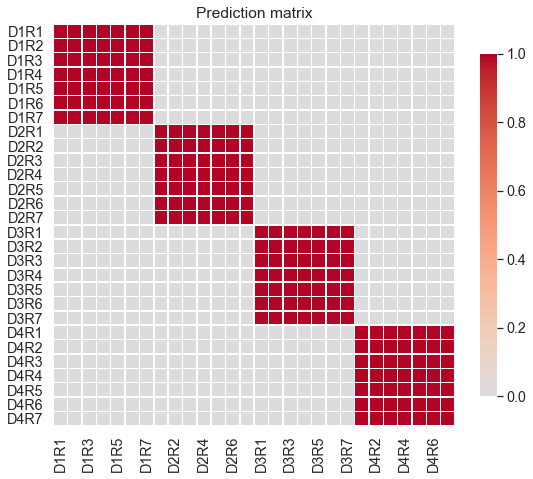

In [451]:
def prediction_matrix():
    pred_mat = np.zeros(28*28).reshape(28, 28)

    for i in range(0,28,7):
        pred_mat[i:i+7,i:i+7] = 1

    pred_df = pd.DataFrame(pred_mat, index=trials, columns=trials)
    return pred_df

def color_ones_red(val):
    color = 'red' if val > 0.0 else 'black'
    return 'color: %s' % color

pred_df = prediction_matrix()

f, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Prediction matrix")
s = sns.heatmap(pred_df, center= 0, cmap= "coolwarm", square=True, linewidths=.5, cbar_kws={"shrink": .7})

In [330]:
# identify same rep/different day indices
# for i in range(7):
#     print(i,i+7, i+14, i+21)
#     pred_df[i,i+7] = 99
#     pred_df[i,i+14] = 99
#     pred_df[i,i+21] = 99
    
#pd.DataFrame(pred_df)
#vech = pd.DataFrame(pred_df).flatten()
#np.where(vech==99)

In [331]:
# define run_RSA_glm function
# What it does:
# vectorizes both prediction matrix and neural matrices per participant, removes same rep different days values,
# runs a linear model and saves the t-values

t_values = {"aHPC":[], "alEC":[]}

def run_RSA_glm():
    triu_cor = np.triu(pred_df, k=1) # upper triangle of corr matrix and remove diagnol
    vech_cor = triu_cor.flatten() # vectorize matrix to 1D
    samerep_diffday_index = [7,  14,  21,  36,  43,  50,  65,  72,  79,  94, 101, 108, 123, 130, 137, 152, 159, 166, 181, 188, 195]
    pred_sim = np.delete(vech_cor, samerep_diffday_index) # remove same rep/different day values
    #print(pred_sim.shape)

    for i_roi in rois_mni:
        print("\n", i_roi)
        #for k,v in list(trial_corr_all[i_roi].items())[3:5]:        
        for k,v in trial_corr_all[i_roi].items():
            triu_cor = np.triu(v, k=1) # upper triangle of corr matrix and remove diagnol
            vech_cor = triu_cor.flatten() # vectorize matrix to 1D
            neural_sim = np.delete(vech_cor, samerep_diffday_index) # remove same rep/different day values

            rsa_df = pd.DataFrame({'neural_sim':neural_sim, 'pred_sim':pred_sim})

            # linear model
            model = smf.glm(formula = 'neural_sim~pred_sim', data=rsa_df)
            result = model.fit()
            #print(result.summary())
            #print('T-values: ', result.tvalues)
            t_values[i_roi].append(result.tvalues[1])
            
    return pd.DataFrame.from_dict(t_values)
            
tvalues_df = run_RSA_glm()


 aHPC

 alEC


In [382]:
tvalues_df["t_virtual_time"] = 0
tvalues_df.head()

,aHPC,alEC,t_virtual_time
0,8.657688,7.637593,0
1,7.054783,8.239200,0
2,10.595632,8.889636,0
3,9.198128,8.586333,0
4,8.220728,10.037740,0


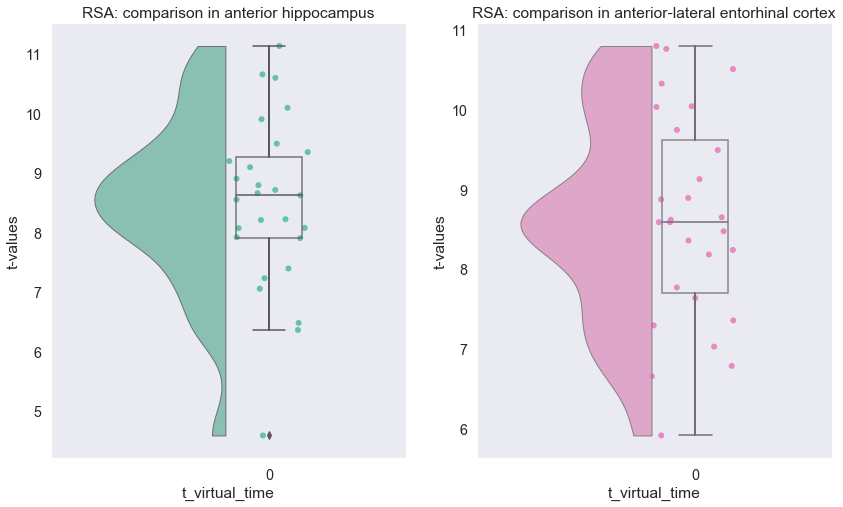

In [448]:
sns.set(style="dark",font_scale=1.3)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

dy="aHPC"; dx="t_virtual_time"; ort="v"; pal = "Set2"
ax[0] = pt.RainCloud(x = dx, y = dy, data = tvalues_df, palette = pal, bw = sigma, offset = 0.1,
                  width_viol = .6, ax = ax[0], orient = ort, alpha = .8, point_size = 6)
ax[0].set(ylabel='t-values')
ax[0].set_title("RSA: comparison in anterior hippocampus")


dy="alEC"; dx="t_virtual_time"; ort="v"; pal = "Set2_r"
ax[1] = pt.RainCloud(x = dx, y = dy, data = tvalues_df, palette = pal, bw = sigma, offset = 0.1,
                  width_viol = .6, ax = ax[1], orient = ort, alpha = .8, point_size = 6)
ax[1].set(ylabel='t-values')
ax[1].set_title("RSA: comparison in anterior-lateral entorhinal cortex")
fig.tight_layout()

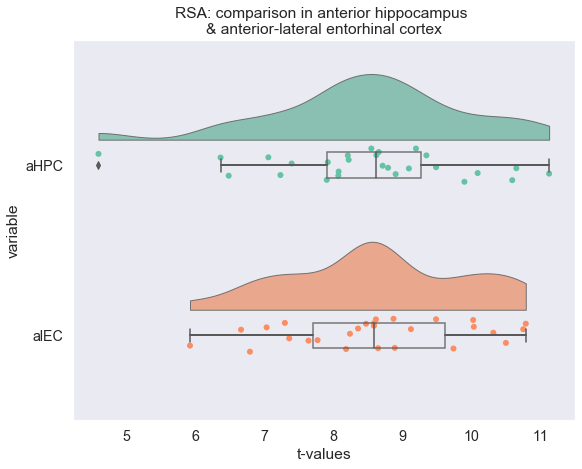

In [449]:
tvalues_melt = pd.melt(tvalues_df, value_vars=["aHPC", "alEC"], value_name="t-values")

sns.set(style="dark",font_scale=1.3)
#same thing with a single command: now x **must** be the categorical value
dx = "variable"; dy = "t-values"; ort = "h"; pal = "Set2"; sigma = 0.3
f, ax = plt.subplots(figsize=(9, 7))

ax = pt.RainCloud(x = dx, y = dy, data = tvalues_melt, palette = pal, bw = sigma, offset = 0.15,
                  width_viol = .8, ax = ax, orient = ort, point_size = 6, alpha=0.8)

ax = plt.title("RSA: comparison in anterior hippocampus \n& anterior-lateral entorhinal cortex")

**One-sample t-test**

In [328]:
# Run one-sample t-test per ROI
from scipy import stats

print('aHPC', stats.ttest_1samp(tvalues_df['aHPC'], 0))
print('alEC', stats.ttest_1samp(tvalues_df['alEC'], 0))

aHPC Ttest_1sampResult(statistic=30.7725646228159, pvalue=5.561703170090544e-22)
alEC Ttest_1sampResult(statistic=34.17925799032071, pvalue=3.866009810436423e-23)


**Statistical comparison of learning stages**
- Take the average of the correlations for comparisons of the first three repetitions (R1 vs. R2, R1 vs. R3, R2 vs. R3) and the last three repetitions (R5 vs. R6, R5 vs. R7, R6 vs. R7) for each participant.
- Separately for same day vs. different days.
- This could give us a good statistical comparison of what happens early (first repetitions) and late (last repetitions) in learning.

In [620]:
len(list(combinations(['D1R1','D1R2','D1R3',
                  'D2R1','D2R2','D2R3',
                  'D3R1','D3R2','D3R3',
                  'D4R1','D4R2','D4R3'],2)))

66

In [660]:

early_reps = []; late_reps = []
sameday_ahpc = pd.DataFrame({'P':participants, 'roi':'aHPC', 'early_reps':0, 'late_reps':0})
sameday_alec = pd.DataFrame({'P':participants, 'roi':'alEC', 'early_reps':0, 'late_reps':0})
diffday_ahpc = pd.DataFrame({'P':participants, 'roi':'aHPC', 'early_reps':0, 'late_reps':0})
diffday_alec = pd.DataFrame({'P':participants, 'roi':'alEC', 'early_reps':0, 'late_reps':0})

for i_roi in rois_mni:
    print(i_roi)
    if i_roi == 'aHPC':
        df1 = sameday_ahpc
        df2 = diffday_ahpc
    elif i_roi == 'alEC':
        df1 = sameday_alec
        df2 = diffday_alec
    #print(df1)
    #print(df2)
    #for p in ['P064']:
    for p in participants:
        #print(p)
        trial = trial_corr_all[i_roi][p]
        
        # same days comparisons
        for d in ['D1', 'D2', 'D3', 'D4']:
            #print(d)
            for early_r in list(combinations(['%sR1'%d,'%sR2'%d,'%sR3'%d],2)):
                #print(early_r[0], early_r[1])
                early_reps.append(trial.loc[early_r[0], early_r[1]])
            for late_r in list(combinations(['%sR5'%d,'%sR6'%d,'%sR7'%d],2)):
                #print(late_r[0], late_r[1])
                late_reps.append(trial.loc[late_r[0], late_r[1]])
        #print(len(late_reps))
        #print(late_reps)
        df1.loc[(df1['P'] == p),'early_reps'] = np.mean(early_reps)
        df1.loc[(df1['P'] == p),'late_reps']  = np.mean(late_reps)
        early_reps = []; late_reps = []
        
        # different days comparisons
        for d in list(combinations(['D1', 'D2', 'D3', 'D4'], 2)):
            for early_r1 in ['R1', 'R2', 'R3']:
                for early_r2 in ['R1', 'R2', 'R3']:
                    #print(d[0]+early_r1, d[1]+early_r2)
                    #print(trial.loc[d[0]+early_r1, d[1]+early_r2])
                    early_reps.append(trial.loc[d[0]+early_r1, d[1]+early_r2])
            for late_r1 in ['R5', 'R6', 'R7']:
                for late_r2 in ['R5', 'R6', 'R7']:
                    #print(d[0]+late_r1, d[1]+late_r2)
                    #print(trial.loc[d[0]+late_r1, d[1]+late_r2])
                    late_reps.append(trial.loc[d[0]+late_r1, d[1]+late_r2])
        #print(len(early_reps))
        #print(len(late_reps))
        df2.loc[(df2['P'] == p),'early_reps'] = np.mean(early_reps)
        df2.loc[(df2['P'] == p),'late_reps']  = np.mean(late_reps)
        early_reps = []; late_reps = []
        
sameday = pd.concat([sameday_ahpc, sameday_alec], axis=0)
diffday = pd.concat([diffday_ahpc, diffday_alec], axis=0)
print(sameday.head())
diffday.head()

aHPC
alEC
      P   roi  early_reps  late_reps
0  P031  aHPC    0.003788   0.005798
1  P032  aHPC    0.005047   0.009423
2  P033  aHPC    0.010339   0.012107
3  P034  aHPC    0.005216   0.006005
4  P035  aHPC    0.005712   0.004788


,P,roi,early_reps,late_reps
0,P031,aHPC,0.004350,0.005215
1,P032,aHPC,0.005389,0.010052
2,P033,aHPC,0.010153,0.011638
3,P034,aHPC,0.005712,0.005422
4,P035,aHPC,0.005752,0.005303


In [744]:
#print(sameday_ahpc.groupby('roi').mean())
#print(diffday_ahpc.groupby('roi').mean())

hpc = pd.DataFrame({"days_group":['same', 'same', 'different', 'different'],
                   "learning_stage":['early', 'late', 'early', 'late'],
                   "average":[sameday_ahpc.mean()['early_reps'], sameday_ahpc.mean()['late_reps'],
                            diffday_ahpc.mean()['early_reps'], diffday_ahpc.mean()['late_reps']]})
hpc

#print(sameday_alec.groupby('roi').mean())
#print(diffday_alec.groupby('roi').mean())
ec = pd.DataFrame({"days_group":['same', 'same', 'different', 'different'],
                   "learning_stage":['early', 'late', 'early', 'late'],
                   "average":[sameday_alec.mean()['early_reps'], sameday_alec.mean()['late_reps'],
                            diffday_alec.mean()['early_reps'], diffday_alec.mean()['late_reps']]})
ec

learn_stage = pd.concat([hpc, ec],axis=0, ignore_index=True)
learn_stage['roi'] = np.repeat(['aHPC','alEC'],4)
learn_stage

,days_group,learning_stage,average,roi
0,same,early,0.007638,aHPC
1,same,late,0.011069,aHPC
2,different,early,0.008104,aHPC
3,different,late,0.011167,aHPC
4,same,early,0.032695,alEC
5,same,late,0.041871,alEC
6,different,early,0.033962,alEC
7,different,late,0.043290,alEC


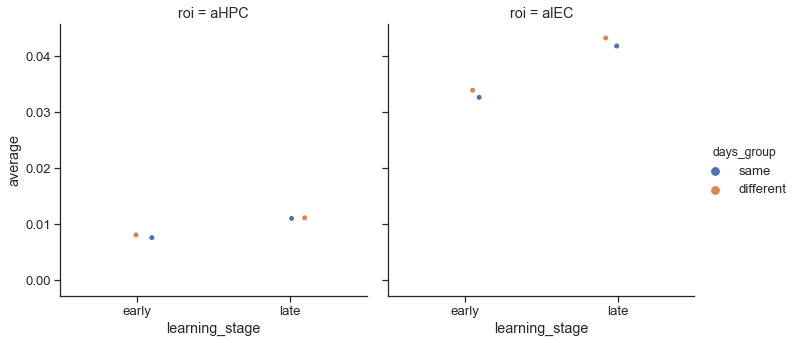

In [756]:
g = sns.catplot(x="learning_stage", y="average", hue="days_group", col="roi",data=learn_stage)

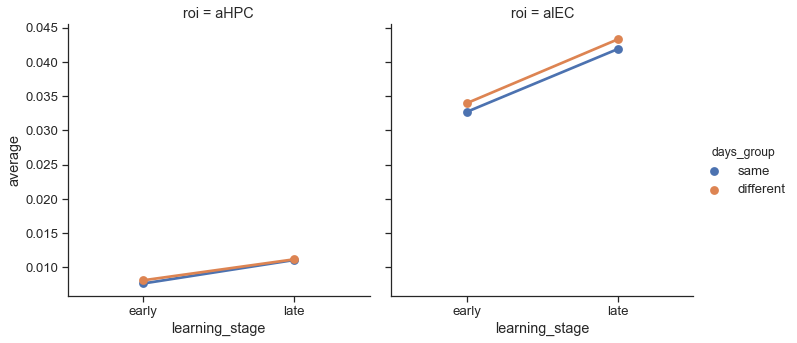

In [754]:
g = sns.catplot(x="learning_stage", y="average", hue="days_group", col="roi", kind="point", data=learn_stage)

# Low-dimensional projection